# Chromosome karyotyping analysis

Chromosome karyotyping analysis is a screening and diagnostic procedure performed in clinical and cancer cytogenetic labs. Chromosome are first stained with a fluorescent dye, and then imaged through a microscope for subsequent analysis and classification. Each chromosome in the image has to be identified and assigned to one of 24 classes: the result is the so-called karyotype image in which all chromosomes in a cell are graphically arranged according to an international system for cytogenetic nomenclature (ISCN) classification. 

Source:
- https://www.fim.uni-passau.de/en/faculty/former-professors/mathematical-stochastics/chromosome-image-data/
- http://bioimlab.dei.unipd.it/Automatic%20Karyotyping%20Classification.htm
- http://bioimlab.dei.unipd.it/Chromosome%20Data%20Set%204Seg.htm
- https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html

This is mainly image processing demo of some of OpenCV library functions and my personal experiments.

In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [32]:
img = cv2.imread('chromosomes_2.tiff')

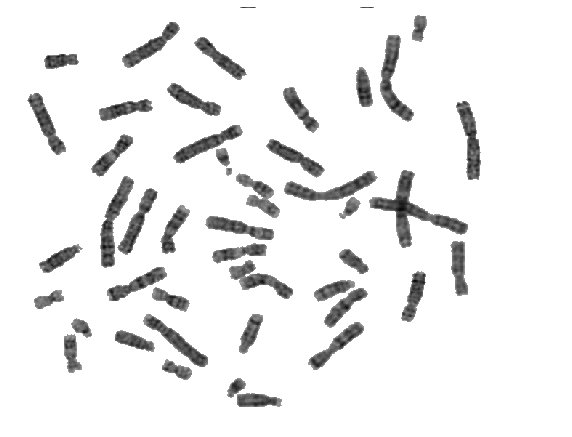

In [33]:
# Draw original figure
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
# convert to gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray.shape

(582, 768)

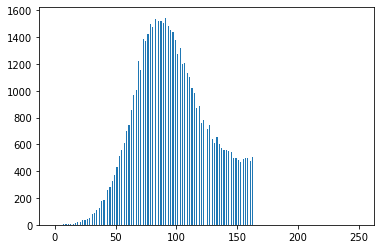

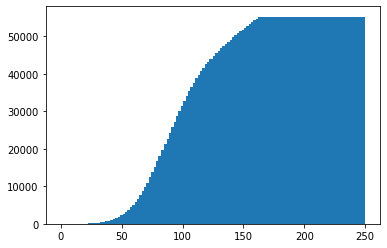

In [35]:
img_gray_flattened = img_gray.ravel()

# show histogram of intensities
# ignore white backgroud (use intensity <= 250)
plt.hist(img_gray_flattened,256,[0,250], cumulative=False)
plt.show()

# show histogram of intensities
plt.hist(img_gray_flattened,256,[0,250], cumulative=True)
plt.show()

# the image has already been somehow pre-processed

In [36]:
# binarize the image using threshold analysis
ret, img_bw = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img_bw.shape

(582, 768)

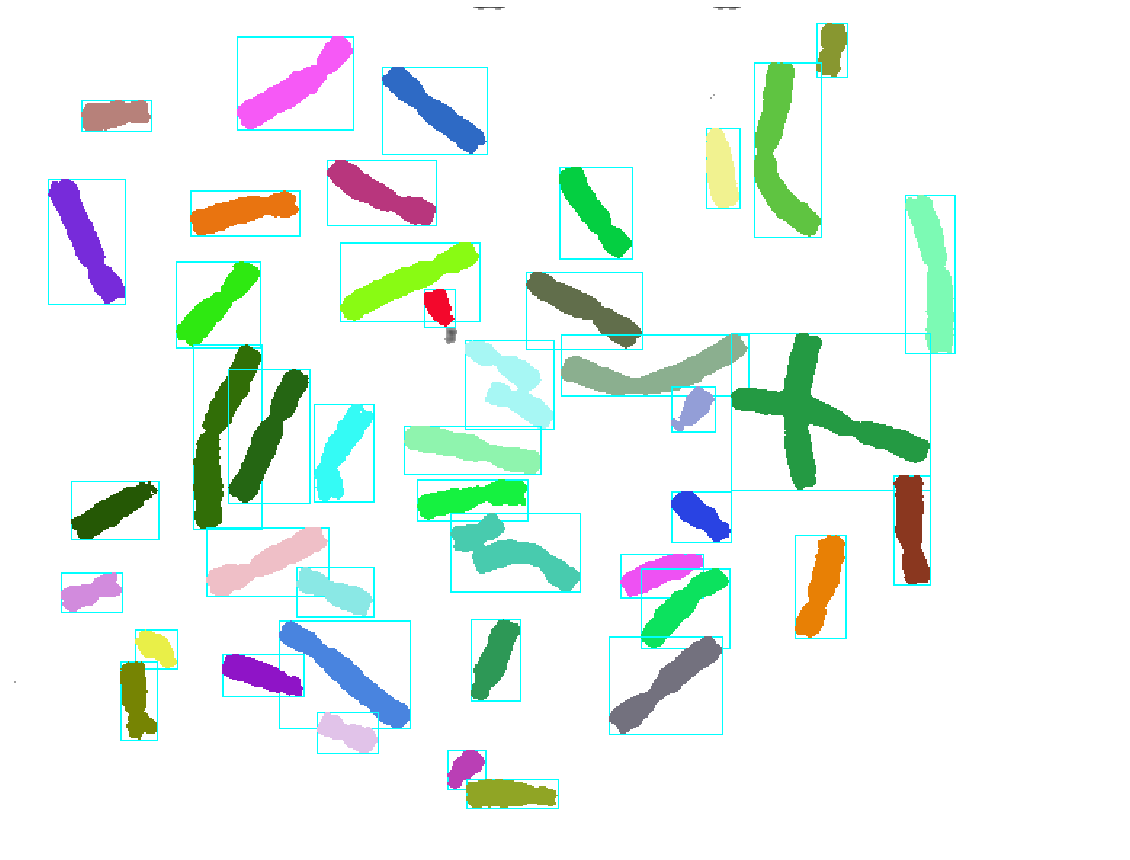

In [37]:
# analyze binary objects - find connected components
connectivity = 4
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_bw, connectivity, cv2.CV_32S)

# copy image
img2 = np.copy(img)

extracted_images = []

# ignore the 1st component
for i in range(1, nb_components):
    x = stats[i][cv2.CC_STAT_LEFT]
    y = stats[i][cv2.CC_STAT_TOP]
    w = stats[i][cv2.CC_STAT_WIDTH]
    h = stats[i][cv2.CC_STAT_HEIGHT]
    area = w*h
    
    if area<100:
        continue
    
    # create new image for an identified object
    img_extracted = np.zeros((h, w))
    img_extracted = 255 - img_extracted # white background
    extracted_images.append(img_extracted)
    
    # copy bytes by mask supplied in 'output' matrix
    for y2 in range(y, y + h):
        for x2 in range(x, x + w):           
            if (output[y2, x2] == i):
                img_extracted[y2 - y, x2 - x] = img_gray[y2, x2]
    
    # draw the bounding rectangele around each object
    cv2.rectangle(
        img2,
        (x, y),
        (x+w, y+h), 
        (255,255,0),
        1)
    
    # set mask color
    color = np.random.randint(255, size=3)
    img2[output == i] = color
        
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

Generating images...


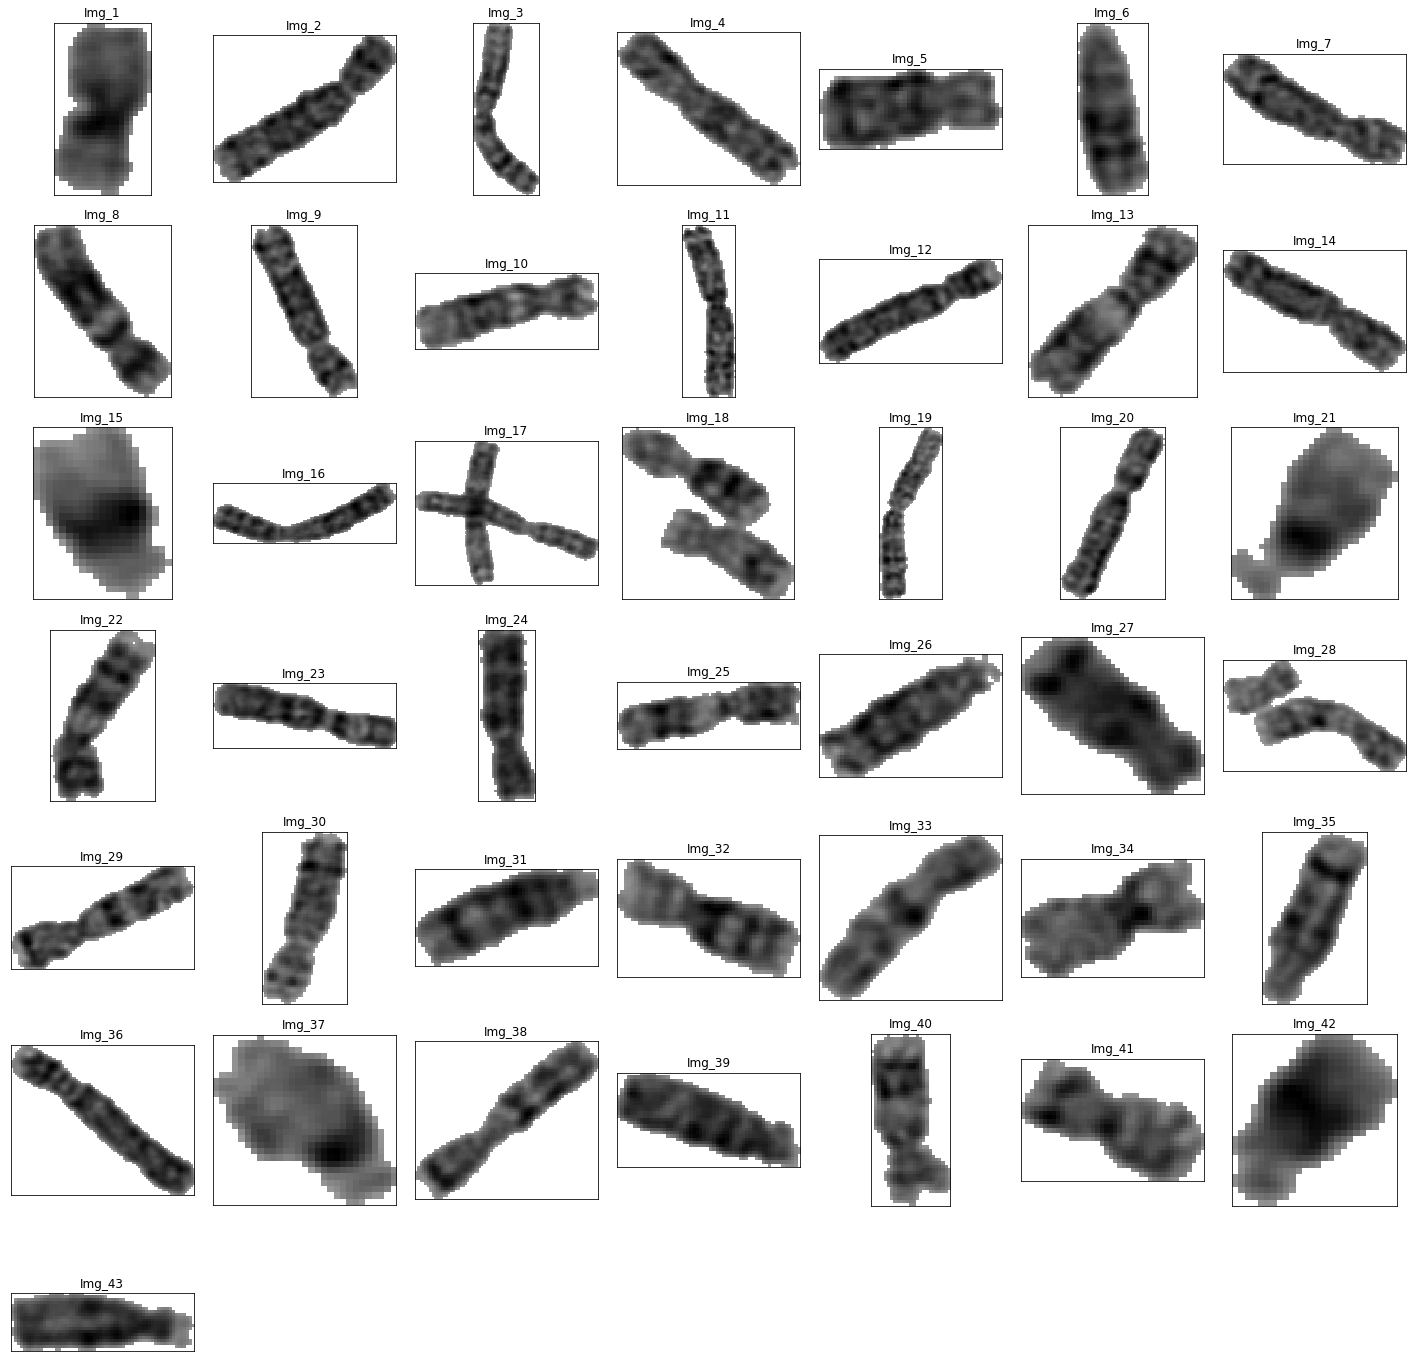

In [38]:
# Show all extracted images
print ('Generating images...')

n_extracted = len(extracted_images)
table_size = (int) (math.sqrt(n_extracted)) + 1

fig = plt.figure(figsize=(20,20))
for i in range(0, n_extracted):
    plt.subplot(table_size,table_size,i+1)
    plt.tight_layout()  
    plt.imshow(extracted_images[i], cmap='gray', interpolation='none')
    plt.title("Img_{}".format(i+1))
    plt.xticks([])
    plt.yticks([])

In [87]:
# the function computes an angle to rotate the object to be vertically oriented
# mechanical moments are used (some physics is needed)
def get_object_deviation(img_gray, background_gray_color):
    w = img_gray.shape[1]
    h = img_gray.shape[0]    # target deviation
    
    alpha = 0
    
    # mechanical moments
    m00 = 0.0   # area
    m10 = 0.0   # linear. moments
    m01 = 0.0
    m20 = 0.0   # kvadrat. moments
    m02 = 0.0
    m11 = 0.0   # deviation moment
    cm20 = 0.0  # central moment
    pm20 = 0.0  # principal kvadratic moment
    cm02 = 0.0
    cm11 = 0.0  # central deviation moment

    #print ('w:', w, 'h:', h)
    
    for x in range(w):
        for y in range(h):
            v = img_gray[y, x]
            if v != background_gray_color:
                x_1 = x + 1.0
                y_1 = y + 1.0
                
                m00 += 1.0;
                m10 += x_1;
                m01 += y_1;
                m11 += x_1 * y_1;
                m02 += y_1 * y_1;
                m20 += x_1 * x_1;
                
    #print ('m00:', m00, 'm10:', m10, 'm01:', m01, 'm20:', m20, 'm02:', m02)

    if m00 == 0.0: # nothing to count
        #print ('m00==0')
        return alpha;     

    xc = m01 / m00;       # center of gravity
    yc = m10 / m00;
    
    #print ('xc:', xc, 'yc:', yc)

    for x in range(w):
        for y in range(h):
            v = img_gray[y, x]
            if v != background_gray_color:
                x_1 = x + 1.0 - xc
                y_1 = y + 1.0 - yc;
                cm02 += y_1 * y_1;
                cm20 += x_1 * x_1;
                cm11 += x_1 * y_1;

    # princial kvadratic moments are the same as moments moved to the center of gravity (Steiner's theorem)
    # in the center of gravity the linear moments are zero
    cm11 = m11 - xc*yc*m00;
    #print ('cm11:', cm11)

    # symetric object
    if cm20 == cm02:
        #print ('cm20 == cm02')
        return alpha

    # symetric object in one axis
    if cm11 == 0.0 and cm20 > cm02:
        #print ('cm11 == 0.0 and cm20 > cm02')
        alpha = 3.141593
        return alpha

    # symetric object in another axis
    if cm11 == 0.0:
        #print ('cm11 == 0.0')
        return alpha

    alpha = 0.5 * math.atan2(2.0 * cm11, (cm20 - cm02)) # = atan(y/x)

    # adjust angle
    alpha = 1.5707963 - alpha
    return alpha

In [88]:
# adapted from imutils.rotate_bound
def rotate_image(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    # white background
    dst = np.zeros((nH, nW))
    dst = 255 - dst

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), dst=dst, borderMode=cv2.BORDER_TRANSPARENT)

In [89]:
rotated_images = []

print ('Rotating images...')

for extracted_image in extracted_images:
    alpha = get_object_deviation(extracted_image, 255)
    alpha_degrees = 180.0*alpha/math.pi
    rotated = rotate_image(extracted_image, alpha_degrees)
    rotated_images.append(rotated)
    
print ('Done.')

Rotating images...
Done.


In [90]:
def crop_image(img_gray, background_gray_color):
    """
    Takes gray image and returns cropped image.
    """
    rows, cols = img_gray.shape
    non_empty_columns = np.where(img_gray.min(axis=0) != background_gray_color)[0]
    non_empty_rows = np.where(img_gray.min(axis=1) != background_gray_color)[0]
    crop_box = (min(non_empty_rows),
                min(max(non_empty_rows), rows),
                min(non_empty_columns),
                min(max(non_empty_columns), cols))
    
    cropped = img_gray[crop_box[0] : crop_box[1]+1, crop_box[2] : crop_box[3]+1]
    return cropped

In [91]:
cropped_images = []

print ('Cropping images...')

for rotated_image in rotated_images:
    cropped = crop_image(rotated_image, 255)
    cropped_images.append(cropped)
    
print ('Done.')

Cropping images...
Done.


Generating images...
Done.


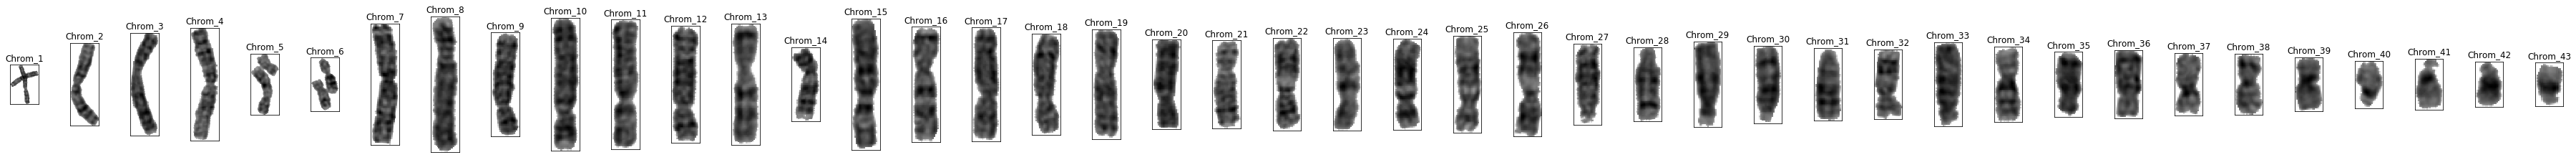

In [92]:
print ('Generating images...')

target_images = sorted(cropped_images, key=lambda image: image.shape[0]*image.shape[1], reverse=True)
n_extracted = len(target_images)

fig = plt.figure(figsize=(50,7))
for i in range(0, n_extracted):
    plt.subplot(1,n_extracted,i+1)
    plt.tight_layout()  
    plt.imshow(target_images[i], cmap='gray', interpolation='none')
    plt.title("Chrom_{}".format(i+1))
    plt.xticks([])
    plt.yticks([])
    
print ('Done.')

Overlapping or touching chromosomes require manual editation. Not covered here.

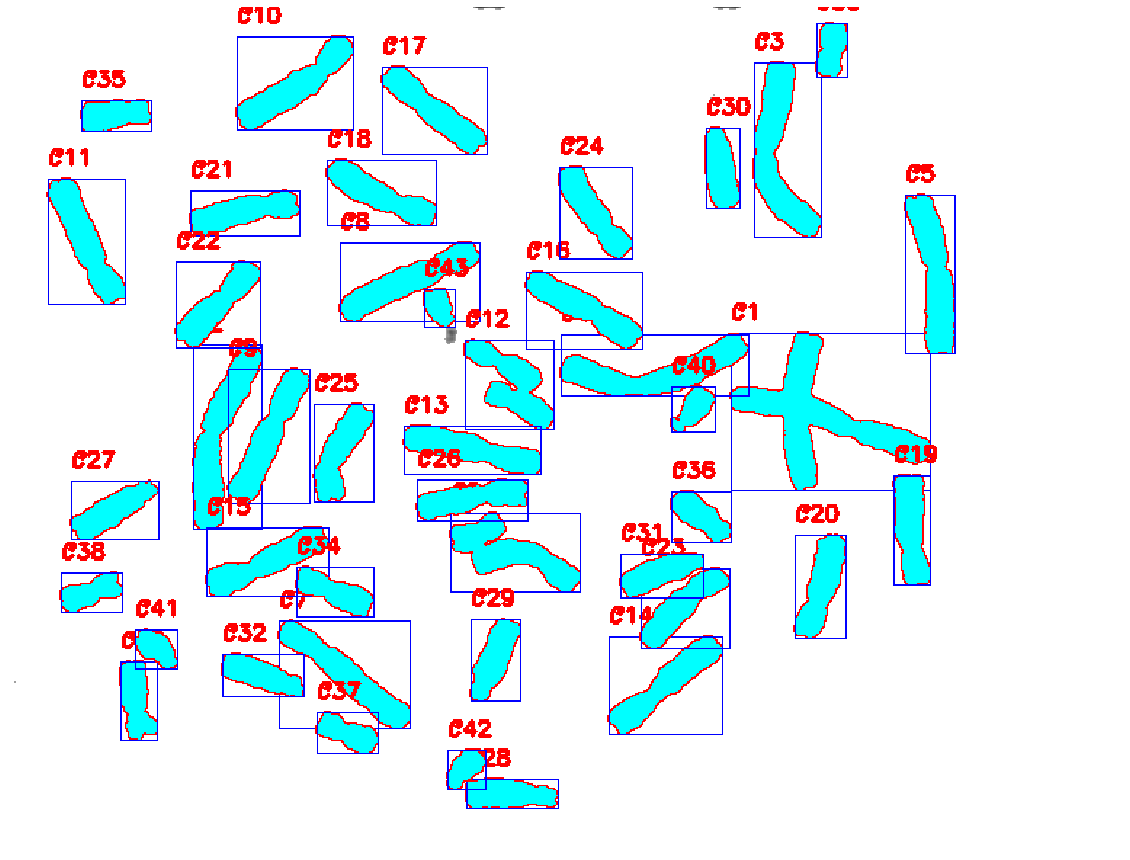

In [86]:
# detect objects by finding contours
img3 = np.copy(img)

contours, hierarchy = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# sort contours
contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending

# draw contours - fill with different border
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    if area<100:
        continue
    
    # border
    cv2.drawContours(img3, [contour], 0, (0,0,255), 2)    
    # fill
    cv2.drawContours(img3, [contour], 0, (255,255,0), -1)
    
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img3, (x, y), (x + w, y + h), (255, 0, 0), 1)
    cv2.putText(img3, "C{}".format(i + 1), (x, y-10), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.5, (0, 0, 255), 2)

# Draw original figure with rectangles
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()